# Token Count & Cost Estimation for Proprietary LLMs

This notebook estimates the token count and cost of running the systematic review screening task with proprietary LLMs (GPT-4, Claude, etc.).

**Approach:**
1. Use `tiktoken` to count tokens (OpenAI tokenizer, broadly applicable)
2. Calculate input tokens per prompt (review title + abstract + template)
3. Estimate output tokens (based on prompt type)
4. Apply pricing for different models

In [1]:
%pip install -q tiktoken pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import tiktoken
from pathlib import Path

DATA_DIR = Path.cwd().parent / "Data" if not (Path.cwd() / "Data").exists() else Path.cwd() / "Data"

# Load validation set
df = pd.read_csv(DATA_DIR / "ground_truth_validation_set.csv")
print(f"Loaded {len(df):,} records")
print(f"Label distribution: {df['label'].value_counts().to_dict()}")

Loaded 1,000 records
Label distribution: {1: 500, 0: 500}


In [3]:
# Define prompt templates (same as evaluation notebook)

ZERO_SHOT_TEMPLATE = """You are a systematic review screener. Based on the abstract below, decide if this paper should be INCLUDED or EXCLUDED from a systematic review about:
"{review_title}"

Abstract:
{abstract}

Answer with exactly one word: INCLUDE or EXCLUDE"""

COT_TEMPLATE = """You are a systematic review screener. Your task is to decide if a paper should be included in a systematic review.

Review topic: "{review_title}"

Abstract to screen:
{abstract}

Think through this step by step:
1. What is the main topic of this paper?
2. Does it relate to the systematic review topic?
3. Does it appear to provide relevant evidence?

After your reasoning, give your final answer on a new line as exactly: DECISION: INCLUDE or DECISION: EXCLUDE"""

print("Templates loaded.")

Templates loaded.


In [4]:
# Initialize tokenizer (cl100k_base is used by GPT-4, GPT-3.5-turbo)
# Claude uses a similar tokenization, so this is a good approximation
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """Count tokens in a string."""
    if pd.isna(text):
        return 0
    return len(enc.encode(str(text)))

# Count tokens for each component
df['title_tokens'] = df['review_title'].apply(count_tokens)
df['abstract_tokens'] = df['paper_abstract'].apply(count_tokens)

# Generate full prompts and count tokens
def make_prompt(row, template):
    abstract = str(row['paper_abstract']) if pd.notna(row['paper_abstract']) else ''
    # Truncate to 3000 chars as done in evaluation
    if len(abstract) > 3000:
        abstract = abstract[:3000]
    return template.format(
        review_title=row['review_title'],
        abstract=abstract
    )

df['zero_shot_prompt'] = df.apply(lambda r: make_prompt(r, ZERO_SHOT_TEMPLATE), axis=1)
df['cot_prompt'] = df.apply(lambda r: make_prompt(r, COT_TEMPLATE), axis=1)

df['zero_shot_input_tokens'] = df['zero_shot_prompt'].apply(count_tokens)
df['cot_input_tokens'] = df['cot_prompt'].apply(count_tokens)

print("Token counting complete.")

Token counting complete.


In [5]:
# Summarize token statistics

print("=" * 60)
print("TOKEN STATISTICS")
print("=" * 60)

print("\n📊 ZERO-SHOT PROMPTS")
print(f"   Total input tokens: {df['zero_shot_input_tokens'].sum():,}")
print(f"   Mean per prompt:    {df['zero_shot_input_tokens'].mean():.0f}")
print(f"   Min:                {df['zero_shot_input_tokens'].min()}")
print(f"   Max:                {df['zero_shot_input_tokens'].max()}")
print(f"   Std:                {df['zero_shot_input_tokens'].std():.0f}")

print("\n📊 CHAIN-OF-THOUGHT PROMPTS")
print(f"   Total input tokens: {df['cot_input_tokens'].sum():,}")
print(f"   Mean per prompt:    {df['cot_input_tokens'].mean():.0f}")
print(f"   Min:                {df['cot_input_tokens'].min()}")
print(f"   Max:                {df['cot_input_tokens'].max()}")
print(f"   Std:                {df['cot_input_tokens'].std():.0f}")

# Estimate output tokens
# Zero-shot: ~1-5 tokens ("INCLUDE" or "EXCLUDE")
# CoT: ~100-200 tokens (reasoning + decision)
ZERO_SHOT_OUTPUT_EST = 5
COT_OUTPUT_EST = 150

n_samples = len(df)

zero_shot_input_total = df['zero_shot_input_tokens'].sum()
zero_shot_output_total = n_samples * ZERO_SHOT_OUTPUT_EST

cot_input_total = df['cot_input_tokens'].sum()
cot_output_total = n_samples * COT_OUTPUT_EST

print("\n" + "=" * 60)
print("ESTIMATED TOTALS")
print("=" * 60)
print(f"\nZero-Shot ({n_samples:,} samples):")
print(f"   Input tokens:  {zero_shot_input_total:,}")
print(f"   Output tokens: {zero_shot_output_total:,} (est. {ZERO_SHOT_OUTPUT_EST} per response)")
print(f"   Total tokens:  {zero_shot_input_total + zero_shot_output_total:,}")

print(f"\nChain-of-Thought ({n_samples:,} samples):")
print(f"   Input tokens:  {cot_input_total:,}")
print(f"   Output tokens: {cot_output_total:,} (est. {COT_OUTPUT_EST} per response)")
print(f"   Total tokens:  {cot_input_total + cot_output_total:,}")

TOKEN STATISTICS

📊 ZERO-SHOT PROMPTS
   Total input tokens: 411,724
   Mean per prompt:    412
   Min:                86
   Max:                944
   Std:                151

📊 CHAIN-OF-THOUGHT PROMPTS
   Total input tokens: 464,964
   Mean per prompt:    465
   Min:                139
   Max:                997
   Std:                151

ESTIMATED TOTALS

Zero-Shot (1,000 samples):
   Input tokens:  411,724
   Output tokens: 5,000 (est. 5 per response)
   Total tokens:  416,724

Chain-of-Thought (1,000 samples):
   Input tokens:  464,964
   Output tokens: 150,000 (est. 150 per response)
   Total tokens:  614,964


In [6]:
# Cost estimation for different models
# Prices as of January 2026 (per 1M tokens)

PRICING = {
    'GPT-4o': {'input': 2.50, 'output': 10.00},
    'GPT-4o-mini': {'input': 0.15, 'output': 0.60},
    'GPT-4-turbo': {'input': 10.00, 'output': 30.00},
    'Claude 3.5 Sonnet': {'input': 3.00, 'output': 15.00},
    'Claude 3.5 Haiku': {'input': 0.80, 'output': 4.00},
    'Claude 3 Opus': {'input': 15.00, 'output': 75.00},
    'Gemini 1.5 Pro': {'input': 1.25, 'output': 5.00},
    'Gemini 1.5 Flash': {'input': 0.075, 'output': 0.30},
}

def calculate_cost(input_tokens, output_tokens, model_pricing):
    """Calculate cost in USD."""
    input_cost = (input_tokens / 1_000_000) * model_pricing['input']
    output_cost = (output_tokens / 1_000_000) * model_pricing['output']
    return input_cost + output_cost

print("=" * 70)
print("COST ESTIMATES BY MODEL")
print("=" * 70)
print(f"\n{'Model':<22} {'Zero-Shot':>12} {'CoT':>12} {'Both':>12}")
print("-" * 70)

cost_data = []
for model, prices in PRICING.items():
    zs_cost = calculate_cost(zero_shot_input_total, zero_shot_output_total, prices)
    cot_cost = calculate_cost(cot_input_total, cot_output_total, prices)
    total = zs_cost + cot_cost
    print(f"{model:<22} ${zs_cost:>10.2f} ${cot_cost:>10.2f} ${total:>10.2f}")
    cost_data.append({
        'Model': model,
        'Zero-Shot Cost': zs_cost,
        'CoT Cost': cot_cost,
        'Total Cost': total,
        'Input $/1M': prices['input'],
        'Output $/1M': prices['output']
    })

cost_df = pd.DataFrame(cost_data)

print("\n" + "=" * 70)
print("Note: Prices are approximate and may vary. Check provider pricing pages.")

COST ESTIMATES BY MODEL

Model                     Zero-Shot          CoT         Both
----------------------------------------------------------------------
GPT-4o                 $      1.08 $      2.66 $      3.74
GPT-4o-mini            $      0.06 $      0.16 $      0.22
GPT-4-turbo            $      4.27 $      9.15 $     13.42
Claude 3.5 Sonnet      $      1.31 $      3.64 $      4.96
Claude 3.5 Haiku       $      0.35 $      0.97 $      1.32
Claude 3 Opus          $      6.55 $     18.22 $     24.78
Gemini 1.5 Pro         $      0.54 $      1.33 $      1.87
Gemini 1.5 Flash       $      0.03 $      0.08 $      0.11

Note: Prices are approximate and may vary. Check provider pricing pages.


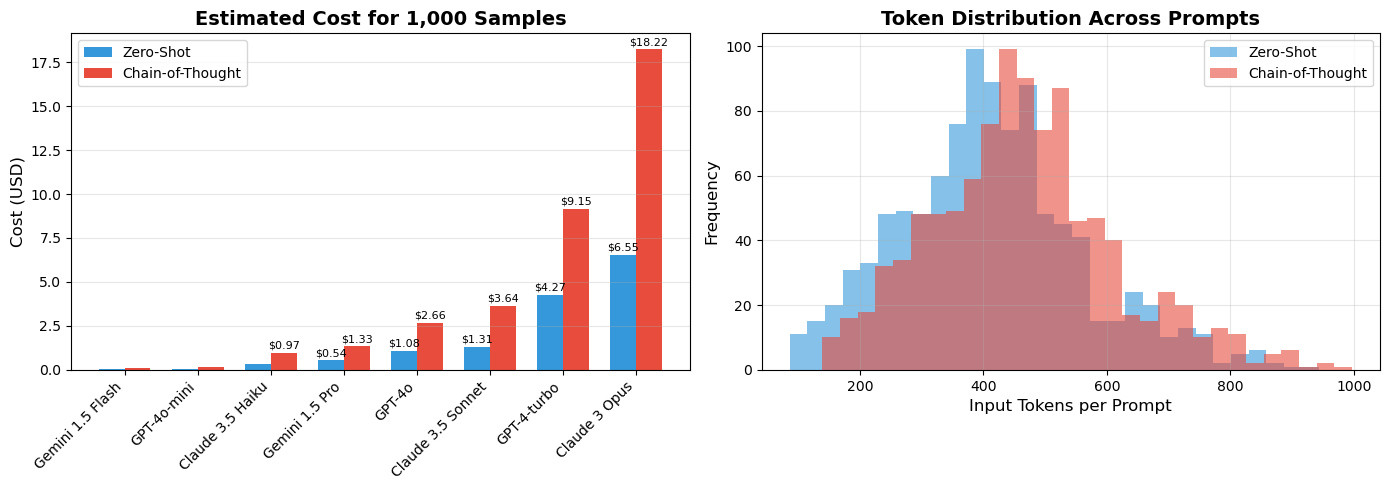


✅ Chart saved to: c:\Users\juanx\Documents\LSE-UKHSA Project\token_cost_analysis.png


In [7]:
# Visualize costs
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort by total cost
cost_df_sorted = cost_df.sort_values('Total Cost')

# Bar chart of costs
ax1 = axes[0]
x = range(len(cost_df_sorted))
width = 0.35
bars1 = ax1.bar([i - width/2 for i in x], cost_df_sorted['Zero-Shot Cost'], width, label='Zero-Shot', color='#3498db')
bars2 = ax1.bar([i + width/2 for i in x], cost_df_sorted['CoT Cost'], width, label='Chain-of-Thought', color='#e74c3c')

ax1.set_ylabel('Cost (USD)', fontsize=12)
ax1.set_title(f'Estimated Cost for {n_samples:,} Samples', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(cost_df_sorted['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add cost labels
for bar in bars1:
    height = bar.get_height()
    if height > 0.5:
        ax1.annotate(f'${height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    if height > 0.5:
        ax1.annotate(f'${height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

# Token distribution
ax2 = axes[1]
ax2.hist(df['zero_shot_input_tokens'], bins=30, alpha=0.6, label='Zero-Shot', color='#3498db')
ax2.hist(df['cot_input_tokens'], bins=30, alpha=0.6, label='Chain-of-Thought', color='#e74c3c')
ax2.set_xlabel('Input Tokens per Prompt', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Token Distribution Across Prompts', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'token_cost_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Chart saved to: {DATA_DIR.parent / 'token_cost_analysis.png'}")

In [8]:
# Summary table
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

cheapest = cost_df.loc[cost_df['Total Cost'].idxmin()]
most_expensive = cost_df.loc[cost_df['Total Cost'].idxmax()]

print(f"\n📊 Dataset: {n_samples:,} paper-review pairs")
print(f"\n💰 Cheapest option: {cheapest['Model']}")
print(f"   Zero-Shot: ${cheapest['Zero-Shot Cost']:.2f}")
print(f"   CoT:       ${cheapest['CoT Cost']:.2f}")
print(f"   Total:     ${cheapest['Total Cost']:.2f}")

print(f"\n💎 Most expensive: {most_expensive['Model']}")
print(f"   Zero-Shot: ${most_expensive['Zero-Shot Cost']:.2f}")
print(f"   CoT:       ${most_expensive['CoT Cost']:.2f}")
print(f"   Total:     ${most_expensive['Total Cost']:.2f}")

print(f"\n📈 Price range: ${cheapest['Total Cost']:.2f} - ${most_expensive['Total Cost']:.2f}")
print(f"   ({most_expensive['Total Cost']/cheapest['Total Cost']:.0f}x difference)")

# Save cost data
cost_df.to_csv(DATA_DIR / 'results' / 'cost_estimates.csv', index=False)
print(f"\n✅ Cost estimates saved to: {DATA_DIR / 'results' / 'cost_estimates.csv'}")


SUMMARY

📊 Dataset: 1,000 paper-review pairs

💰 Cheapest option: Gemini 1.5 Flash
   Zero-Shot: $0.03
   CoT:       $0.08
   Total:     $0.11

💎 Most expensive: Claude 3 Opus
   Zero-Shot: $6.55
   CoT:       $18.22
   Total:     $24.78

📈 Price range: $0.11 - $24.78
   (221x difference)

✅ Cost estimates saved to: c:\Users\juanx\Documents\LSE-UKHSA Project\Data\results\cost_estimates.csv


In [9]:
# Scale up estimates - what if we had more papers?
print("\n" + "=" * 70)
print("SCALING ESTIMATES (GPT-4o-mini as baseline)")
print("=" * 70)

# Use median tokens per prompt for scaling
median_zs_tokens = df['zero_shot_input_tokens'].median()
median_cot_tokens = df['cot_input_tokens'].median()

gpt4o_mini = PRICING['GPT-4o-mini']

print(f"\nMedian tokens per prompt: {median_zs_tokens:.0f} (ZS), {median_cot_tokens:.0f} (CoT)")
print(f"\n{'Papers':>10} {'Zero-Shot':>12} {'CoT':>12} {'Total':>12}")
print("-" * 50)

for n in [1000, 5000, 10000, 50000, 100000]:
    zs_in = n * median_zs_tokens
    zs_out = n * ZERO_SHOT_OUTPUT_EST
    cot_in = n * median_cot_tokens
    cot_out = n * COT_OUTPUT_EST
    
    zs_cost = calculate_cost(zs_in, zs_out, gpt4o_mini)
    cot_cost = calculate_cost(cot_in, cot_out, gpt4o_mini)
    
    print(f"{n:>10,} ${zs_cost:>10.2f} ${cot_cost:>10.2f} ${zs_cost + cot_cost:>10.2f}")

print("\n💡 GPT-4o-mini offers excellent value for large-scale screening.")
print("   Even 100,000 papers with CoT prompts costs under $40.")


SCALING ESTIMATES (GPT-4o-mini as baseline)

Median tokens per prompt: 404 (ZS), 457 (CoT)

    Papers    Zero-Shot          CoT        Total
--------------------------------------------------
     1,000 $      0.06 $      0.16 $      0.22
     5,000 $      0.32 $      0.79 $      1.11
    10,000 $      0.64 $      1.59 $      2.22
    50,000 $      3.18 $      7.93 $     11.11
   100,000 $      6.36 $     15.86 $     22.21

💡 GPT-4o-mini offers excellent value for large-scale screening.
   Even 100,000 papers with CoT prompts costs under $40.
